# Goal

The goal here is to write everything with modular code and then conduct experiments that allow us to get ECN networks to work properly on the CityScapes dataset. We will try a few different approaches to improve results:

* Try different architectures, including a two-stage approach, as well as trying to predict residuals rather than the original $y$ labels
* Increasing the receptive field size on the input as well as the output


# Setup

In [1]:
import os
import matplotlib.pyplot as plt
import argparse
import numpy as np
import random

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

from model.unet import unet, unet_small, dice_coef
from model.fcn import fcn_8s
from model.pspnet import pspnet50
from dataset_parser import generator_miscl, generator

from scripts import *

%load_ext autoreload
%autoreload 2

print('GPUs available:', K.tensorflow_backend._get_available_gpus())

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.






GPUs available: ['/job:localhost/replica:0/task:0/device:GPU:0']


# Combined`

In [2]:
TRAIN_N = 2975
VAL_N = 500
CLEAN_N = 500

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)

def combined_iterator():
    miscl_generator = generator_miscl.data_generator('dataset_parser/data.h5', TRAIN_BATCH, 'train', ignore_pedestrians=ignore_pedestrians, misclassified_frac=0.75)
    f = generator.data_generator('dataset_parser/data.h5', TRAIN_BATCH, 'train', ignore_pedestrians=ignore_pedestrians)
    
    while True:
        if random.random() < (TRAIN_N / (TRAIN_N + CLEAN_N)):
            yield next(miscl_generator)
        else:
            yield next(f)
            
comb = combined_iterator()

# Combined Model

In [3]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None

model_name = "modular_unet_combined_benchmark_other_metrics-100.h5"

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)

combin_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)









Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



In [4]:
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor='val_dice_coef',
                             mode='max',
                             save_best_only=True,
                             save_weights_only=True)

In [5]:
history = combin_model.fit_generator(comb,
                                     steps_per_epoch= (TRAIN_N + CLEAN_N) // TRAIN_BATCH,
                                     validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                     validation_steps= VAL_N // VAL_BATCH,
                                     callbacks=[checkpoint],
                                     epochs=4, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/4
2975
2975
500
500

2975
2975

868/868 [==============================] - 294s 339ms/step - loss: 0.2864 - dice_coef: 0.8356 - normalized_iou_coef: 0.5034 - hard_normalized_hard_iou_coef: nan - val_loss: 0.3511 - val_dice_coef: 0.8496 - val_normalized_iou_coef: 0.5340 - val_hard_normalized_hard_iou_coef: 0.5291
Epoch 2/4
868/868 [==============================] - 289s 333ms/step - loss: 0.2044 - dice_coef: 0.8847 - normalized_iou_coef: 0.5564 - hard_normalized_hard_iou_coef: nan - val_loss: 0.2483 - val_dice_coef: 0.8587 - val_normalized_iou_coef: 0.5656 - val_hard_normalized_hard_iou_coef: 0.5545
Epoch 3/4
868/868 [==============================] - 290s 334ms/step - loss: 0.1796 - dice_coef: 0.8993 - normalized_iou_coef: 0.5858 - hard_normalized_hard_iou_coef: nan - val_loss: 0.2518 - val_dice_coef: 0.8763 - val_normalized_iou_coef: 0.5899 - val_hard_normalized_hard_iou_coef: 0.555

In [6]:
history = combin_model.fit_generator(comb,
                                     steps_per_epoch= (TRAIN_N + CLEAN_N) // TRAIN_BATCH,
                                     validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                     validation_steps= VAL_N // VAL_BATCH,
                                     callbacks=[checkpoint],
                                     epochs=1, verbose=1)

Epoch 1/1
500
500
868/868 [==============================] - 291s 336ms/step - loss: 0.1549 - dice_coef: 0.9128 - normalized_iou_coef: 0.6048 - hard_normalized_hard_iou_coef: nan - val_loss: 0.2352 - val_dice_coef: 0.8822 - val_normalized_iou_coef: 0.6116 - val_hard_normalized_hard_iou_coef: 0.5632


2975
2975
2975
2975
0
80293.10747001506 3922.8118496430106 9444.892529070377
0.857275373607656
1
368.7470775065012 483.360114407905 2673.2529222369194
0.10459841422335693
2
36119.810458046384 9884.162959396705 2172.1895427703857
0.7497444428664048

0
81460.0 3402.0 8278.0
0.8745973802877389
1
2.0 0.0 3040.0
0.0006574621959237344
2
37082.0 9126.0 1210.0
0.78202370407862

0
60313.42784523219 4666.518447314156 5267.572154402733
0.858584462179698
1
9270.696737427264 760.2963939702331 15846.303265035152
0.3582560015313381
2
38201.87108835578 17859.18938261034 2172.1289110183716
0.6560154354206509

0
61469.0 1997.0 4112.0
0.90960075764302
1
552.0 4.0 24565.0
0.02197364754587795
2
39893.0 27157.0 481.0
0.5907361063807732

0
55043.7359032603 6537.916436939966 7384.264095008373
0.7981295507755951
1
10692.630539887265 917.9349298291729 20469.369459927082
0.3333121018897928
2
35229.733904931694 22650.048156406447 2252.2660942077637
0.5858728412809351

0
55535.0 4075.0 6893.0
0.8350751093935612
1


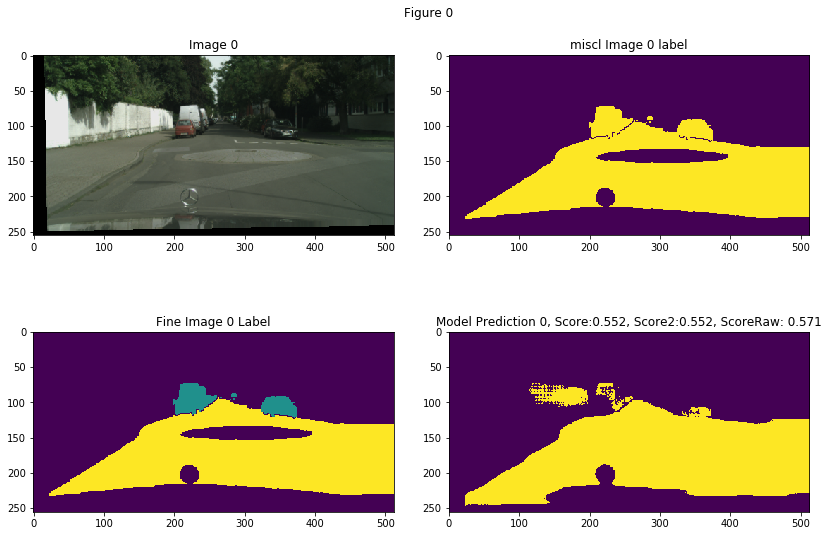

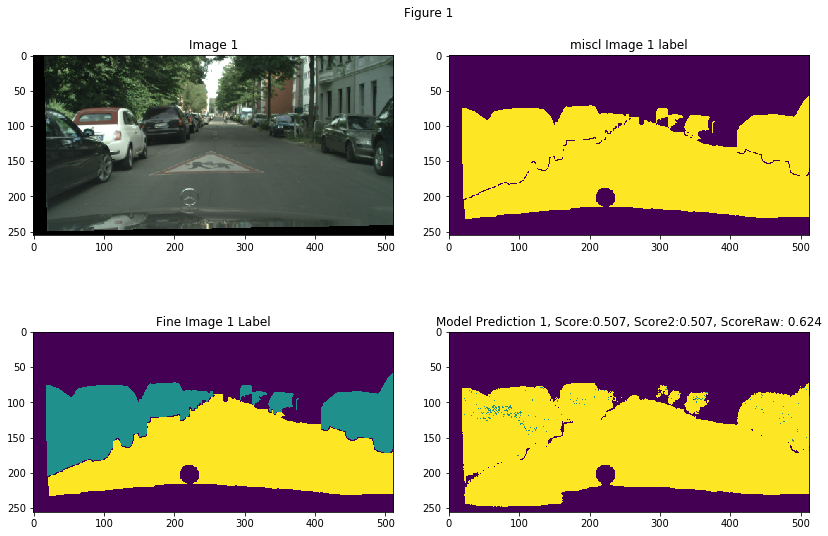

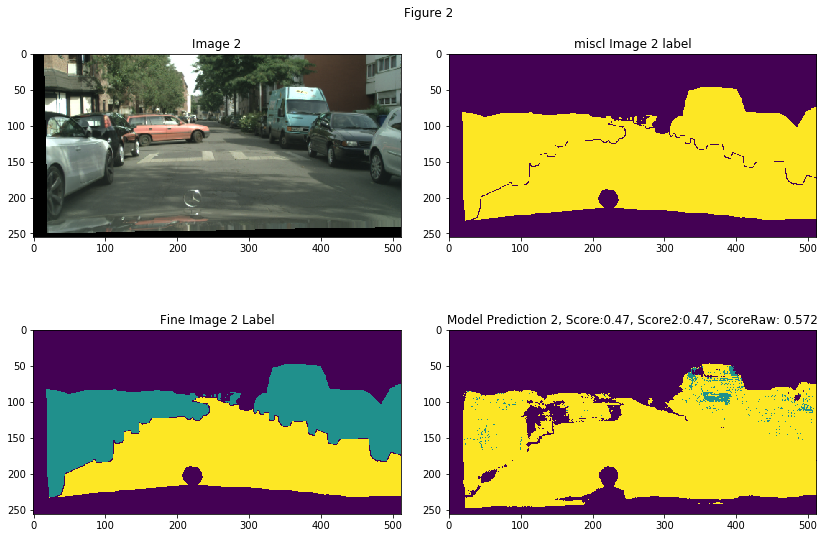

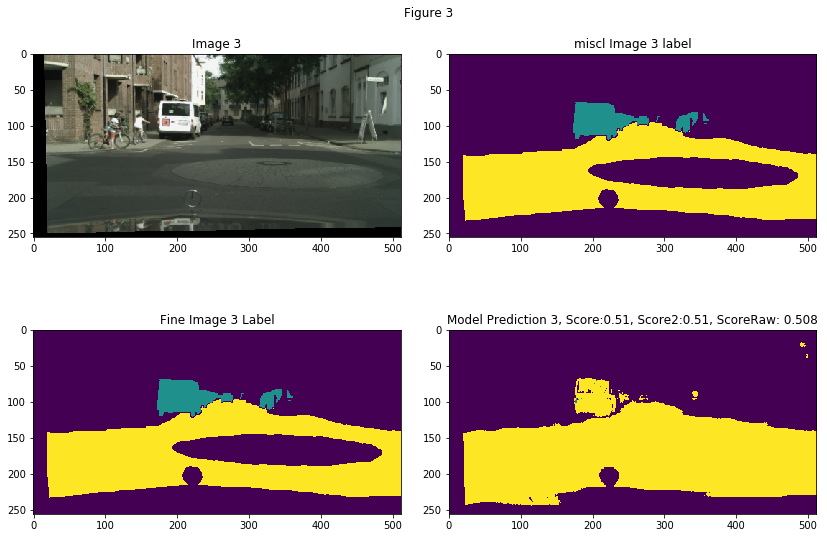

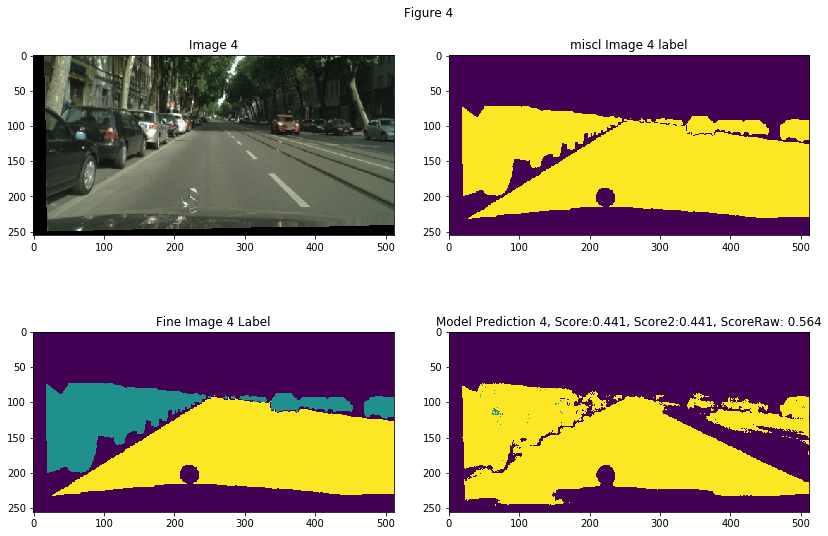

In [7]:
view_paired_predictions_on_training_data(combin_model, ignore_pedestrians=ignore_pedestrians, coarse_or_miscl='miscl')

# Train a Model on Misclassified Data

In [8]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None
model_name = "modular_unet_miscl_weights.h5"
TRAIN_N = 2975
VAL_N = 500

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)

coarse_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

In [9]:
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor='val_dice_coef',
                             save_best_only=True,
                             save_weights_only=True)

In [10]:
miscl_generator = generator_miscl.data_generator('dataset_parser/data.h5', TRAIN_BATCH, 'train', ignore_pedestrians=ignore_pedestrians, misclassified_frac=0.75)

In [11]:
history = coarse_model.fit_generator(miscl_generator,
                                     steps_per_epoch= TRAIN_N // TRAIN_BATCH,
                                     validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                     validation_steps=VAL_N // VAL_BATCH,
                                     callbacks=[checkpoint],
                                     epochs=5, verbose=1)

Epoch 1/5
500
500
2975
2975
743/743 [==============================] - 255s 343ms/step - loss: 0.3042 - dice_coef: 0.8239 - normalized_iou_coef: 0.4842 - hard_normalized_hard_iou_coef: nan - val_loss: 0.4495 - val_dice_coef: 0.7855 - val_normalized_iou_coef: 0.4733 - val_hard_normalized_hard_iou_coef: 0.4720
Epoch 2/5
743/743 [==============================] - 250s 336ms/step - loss: 0.2122 - dice_coef: 0.8805 - normalized_iou_coef: 0.5424 - hard_normalized_hard_iou_coef: nan - val_loss: 0.3076 - val_dice_coef: 0.8607 - val_normalized_iou_coef: 0.5447 - val_hard_normalized_hard_iou_coef: 0.5390
Epoch 3/5
743/743 [==============================] - 250s 337ms/step - loss: 0.1903 - dice_coef: 0.8939 - normalized_iou_coef: 0.5615 - hard_normalized_hard_iou_coef: nan - val_loss: 0.3103 - val_dice_coef: 0.8622 - val_normalized_iou_coef: 0.5491 - val_hard_normalized_hard_iou_coef: 0.5382
Epoch 4/5
743/743 [==============================] - 251s 338ms/step - loss: 0.1734 - dice_coef: 0.9032 - 

# View Predictions

Manually view them to confirm that the predictions on the training set are similar to the training labels

2975
2975
2975
2975
0
82684.28635116853 5495.725368883926 7053.713648915291
0.8682248439911551
1
420.3903163706418 439.88694180834716 2621.609682917595
0.1207363488483185
2
34201.090257694945 7830.620776242062 4090.909741282463
0.7415253010962971

0
83981.0 3731.0 5757.0
0.8984904085846644
1
0.0 0.0 3042.0
0.0
2
36181.0 7179.0 2111.0
0.7956939587869192

0
61288.848531858996 9921.484050515108 4292.151466012001
0.8117461207313624
1
5464.807513946667 521.9126785389478 19652.19247764349
0.21314505744674192
2
36385.945340752834 17489.001858341184 3988.0546602010727
0.6288292029720854

0
62042.0 5470.0 3539.0
0.87320375504919
1
3.0 0.0 25114.0
0.00011944101604490982
2
39068.0 24489.0 1306.0
0.6023156499082682

0
58335.13529407233 15207.768476617057 4092.864705681801
0.7513950906768818
1
7087.810689237434 756.2527117519514 24074.18930208683
0.22206136266833698
2
29053.940647317446 20631.092102556227 8428.059351444244
0.49995516667161727

0
58820.0 10419.0 3608.0
0.8074457424464975
1
5.0 0.0 3

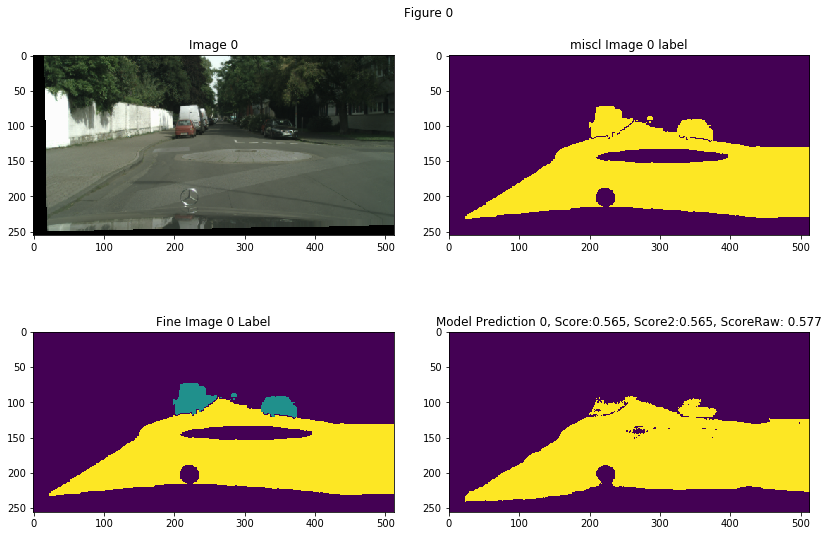

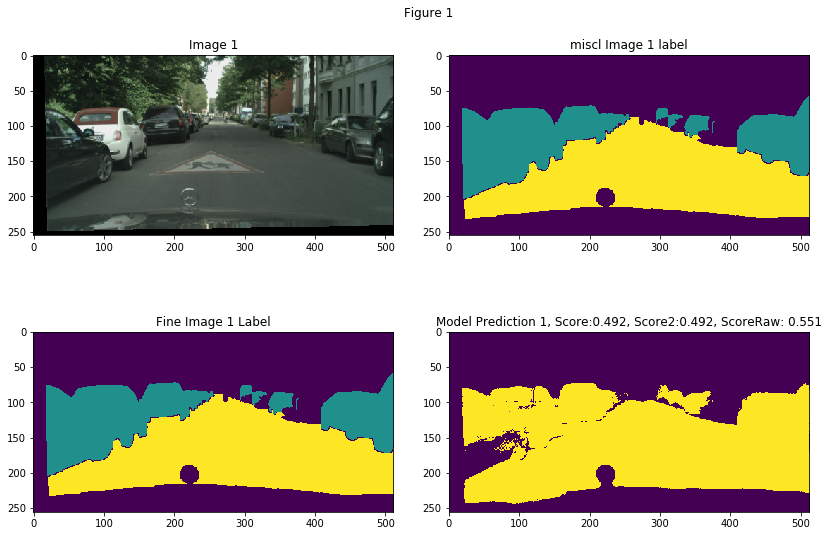

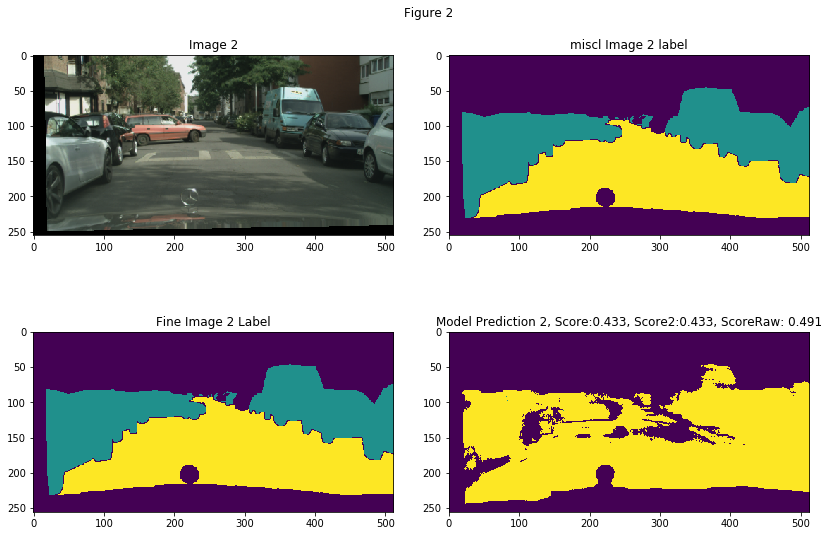

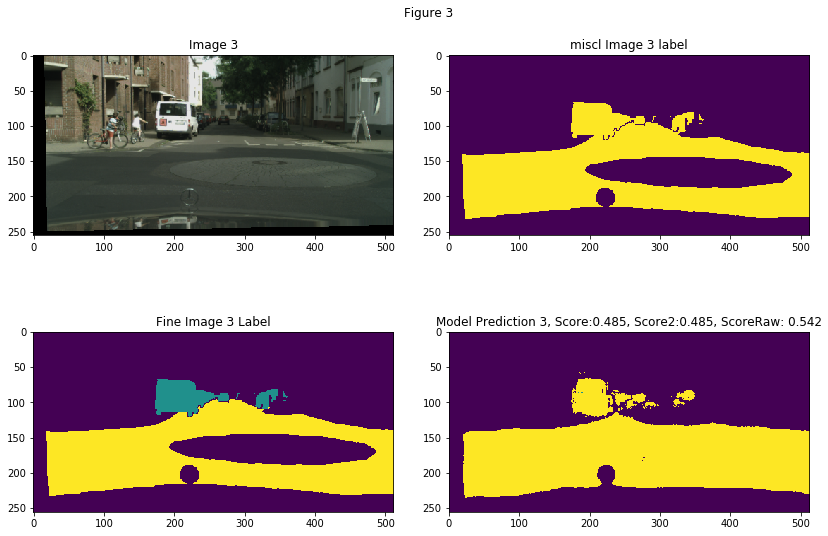

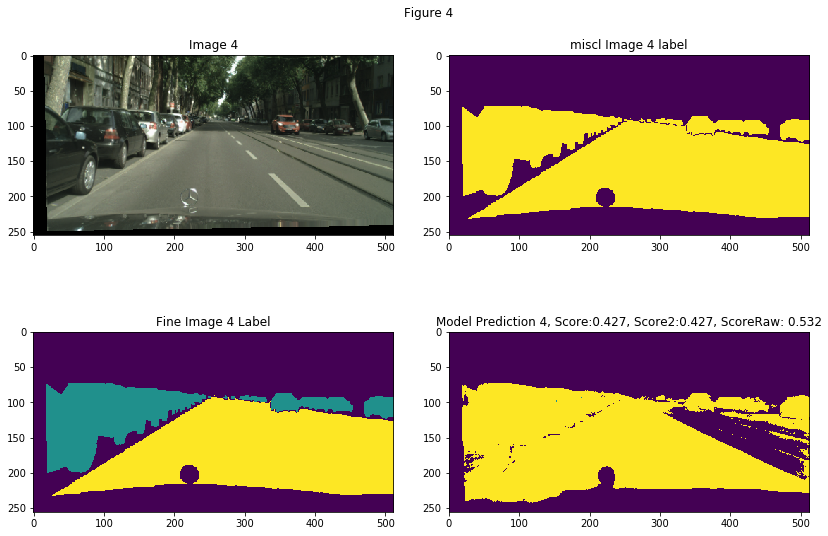

In [12]:
view_paired_predictions_on_training_data(coarse_model, ignore_pedestrians=ignore_pedestrians, coarse_or_miscl='miscl')

# Get Error-Correcting Model

In [13]:
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D, Lambda
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

input_window_size = 64
output_window_size = 1

# ec_model = get_ec_model(input_window_size, output_window_size, dice_coef=dice_coef)

lr_init = 1e-3
lr_decay = 5e-4

inp_y = Input(shape=(input_window_size, input_window_size, 3))
inp_x = Input(shape=(input_window_size, input_window_size, 3))

h = Concatenate()([inp_x, inp_y])
h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
h = MaxPool2D((2, 2), padding='same')(h)
h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
h = MaxPool2D((2, 2), padding='same')(h)
h = Conv2D(16, (4, 4), padding='same', activation='relu')(h)
h = Flatten()(h)
h = Dense(40, activation='relu')(h)
h = Dense(3, activation='softmax')(h)
h = Reshape((1, 1, 3))(h)
ec_model = Model(inputs=[inp_x, inp_y], outputs=h)

# h = Concatenate()([inp_x, inp_y])
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Conv2D(16, (4, 4), padding='same', activation='relu')(h)
# h = Flatten()(h)
# h = Dense(40, activation='relu')(h)
# h = Dense(3, activation='softmax')(h)
# h = Reshape((1, 1, 3))(h)
# ec_model = Model(inputs=[inp_x, inp_y], outputs=h)

# h = Concatenate()([inp_y, inp_x])
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(inp_y)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Flatten()(h)
# h = Dense(3, activation='softmax')(h)
# h = Reshape((1, 1, 3))(h)
# ec_model = Model(inputs=inp_y, outputs=h)

ec_model.summary()
metrics=['mean_squared_error', dice_coef]
ec_model.compile(optimizer=Adam(lr=lr_init, decay=lr_decay),
                 loss='categorical_crossentropy', metrics=metrics)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 64, 64, 6)    0           input_4[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 64, 8)    776         concatenate_9[0][0]              
__________

# Train EC Model 

In [14]:
test_get_ec_batch()

Test 1 passed
Test 2 passed
Test 3 passed


In [15]:
n_epochs = 5
batch_size = 8
skip = 12
N_CLEAN = 500
best_val = 0

val_generator = generator.data_generator('dataset_parser/data.h5', 32, 'val', ignore_pedestrians=True)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)
x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=input_window_size,
    output_window_size=output_window_size, skip=skip, diff=False)

for e in range(n_epochs):
    fine_generator = generator.data_generator('dataset_parser/data.h5', batch_size, 'train', 
                                              ignore_pedestrians=ignore_pedestrians)
    for i in range(N_CLEAN // batch_size):
        x, y_fine = next(fine_generator)
        y_coarse = coarse_model.predict(x)
        x_batch, y_coarse_batch, y_diff_batch = get_ec_batch(x, y_fine, y_coarse, input_window_size=input_window_size,
                                                             output_window_size=output_window_size, skip=skip, diff=False,
                                                             balanced=True)
        
#         metrics = ec_model.train_on_batch(y_coarse_batch, y_diff_batch)
        metrics = ec_model.train_on_batch([x_batch, y_coarse_batch], y_diff_batch)
        print(i, metrics)
    
#     metrics = ec_model.evaluate(y_val_coarse_batch, y_val_diff_batch)
    metrics = ec_model.evaluate([x_val_batch, y_val_coarse_batch], y_val_diff_batch)
    print('\nEpoch {}, batch {}, Validation metrics (loss, mse, dice): {}'.format(e, i, metrics))
    if metrics[-1] > best_val:
        best_val = metrics[-1]
        ec_model.save('best-ec-model-5.h5')
        print('Model saved')

500
500
2975
2975
0 [1.0507104, 0.20998943, 0.36388764]
1 [0.89910346, 0.1776385, 0.489935]
2 [0.93096876, 0.17082039, 0.46927527]
3 [0.8236751, 0.1624673, 0.49641246]
4 [0.7395887, 0.13674352, 0.5177665]
5 [0.61214787, 0.110198945, 0.610326]
6 [0.5731181, 0.104858726, 0.65283257]
7 [0.4867654, 0.08661523, 0.7180126]
8 [0.53638095, 0.10215301, 0.7128172]
9 [0.51351976, 0.098565236, 0.7285799]
10 [0.47733605, 0.08919784, 0.74355495]
11 [0.56640804, 0.0984112, 0.7175431]
12 [0.4752767, 0.088557914, 0.72771263]
13 [0.58290815, 0.10238683, 0.70573926]
14 [0.5035743, 0.09380248, 0.7055385]
15 [0.55628824, 0.099940136, 0.7232849]
16 [0.5350321, 0.09575367, 0.7170231]
17 [0.41968864, 0.0782406, 0.7513039]
18 [0.54520315, 0.09877404, 0.7148666]
19 [0.5447863, 0.098875865, 0.7396222]
20 [0.67357105, 0.11814773, 0.6791843]
21 [0.5708321, 0.10080783, 0.7144001]
22 [0.73715603, 0.12555045, 0.700178]
23 [0.39582643, 0.07035659, 0.7512468]
24 [0.407472, 0.07431278, 0.7409072]
25 [0.51320535, 0.09495

In [16]:
identity_model = get_identity_model()

In [17]:
val_generator = generator.data_generator('dataset_parser/data.h5', 32, 'val', ignore_pedestrians=True)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)

x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=1,
    output_window_size=1, skip=12, diff=False)

500
500


In [18]:
metrics = identity_model.evaluate(y_val_coarse_batch, y_val_diff_batch)
metrics

30272/30272 [==============================] - 2s 71us/step


[0.23915341248420505, 0.04506718490252634, 0.8694249432510351]

# See Corrected Data (X, Y)

2975
2975
2975
2975


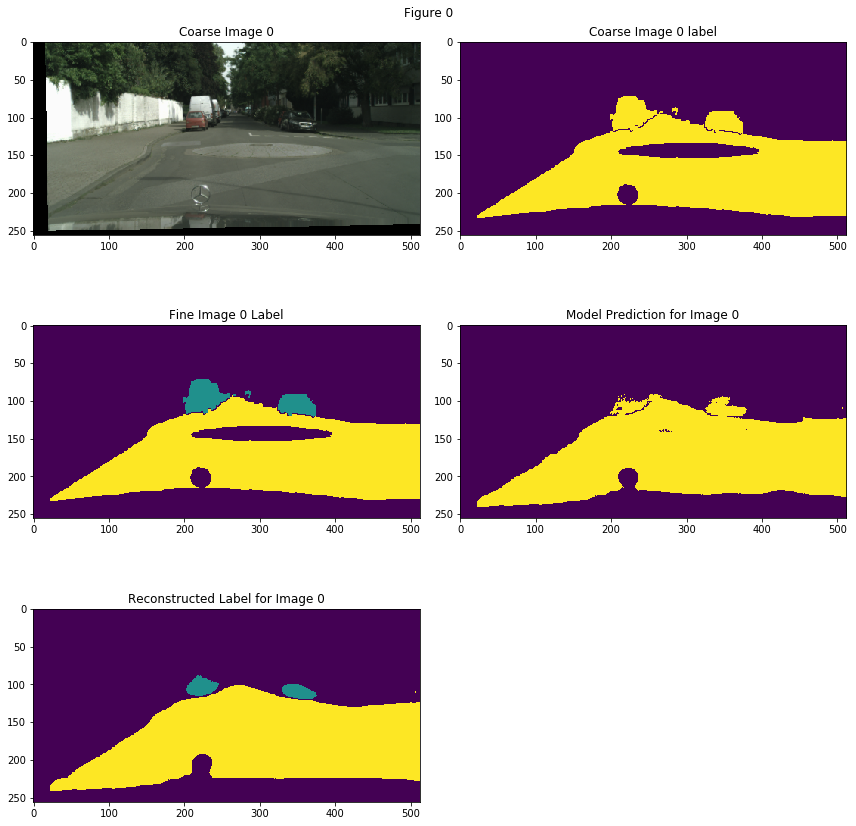

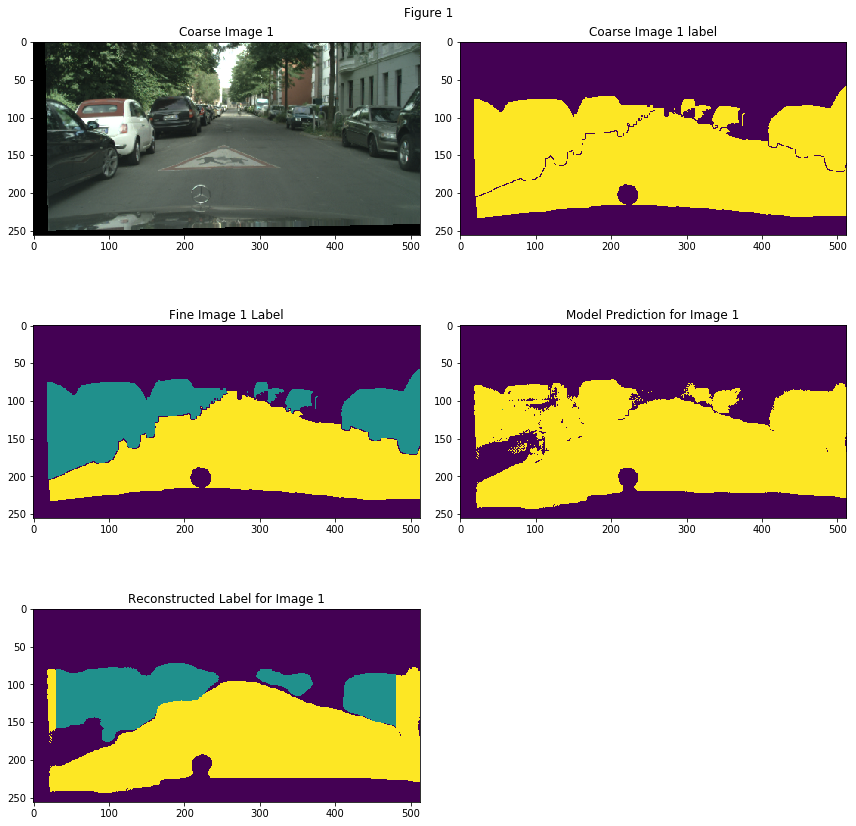

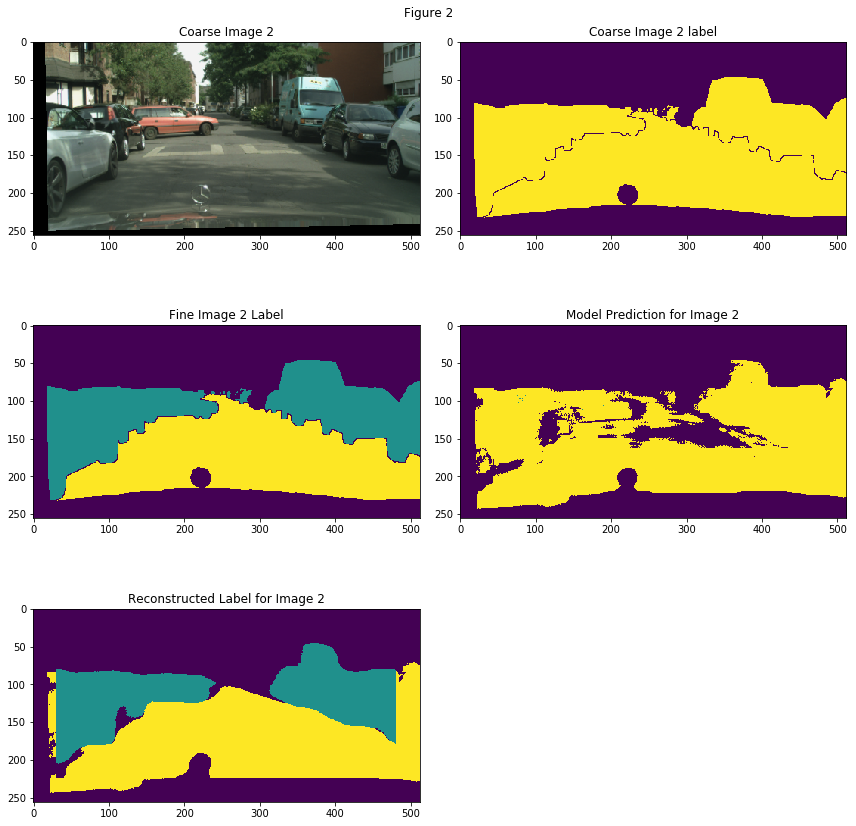

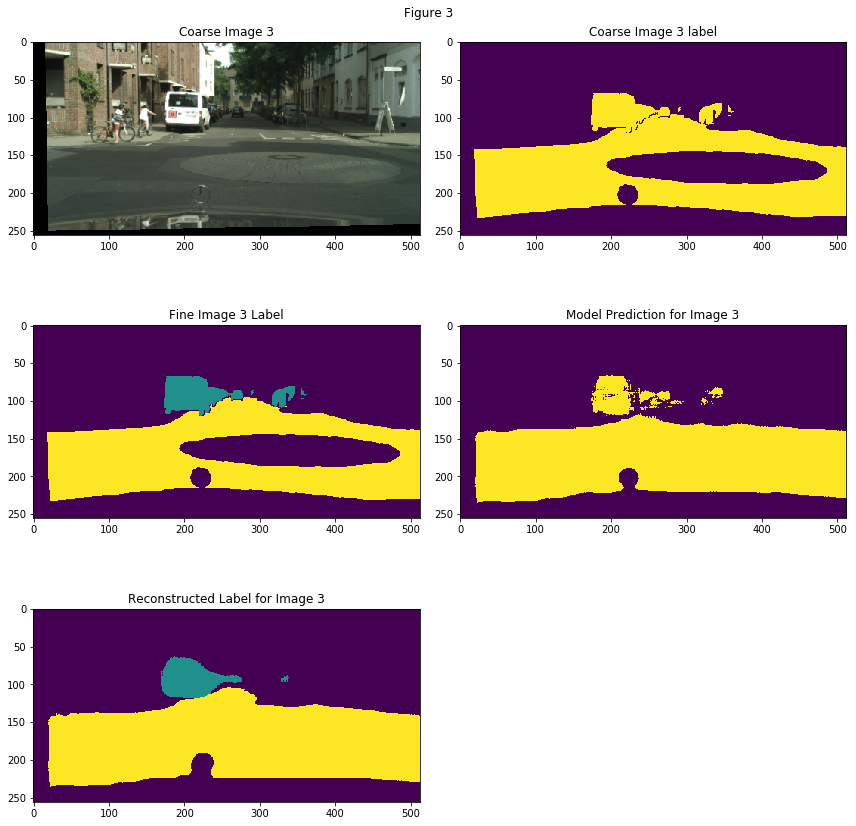

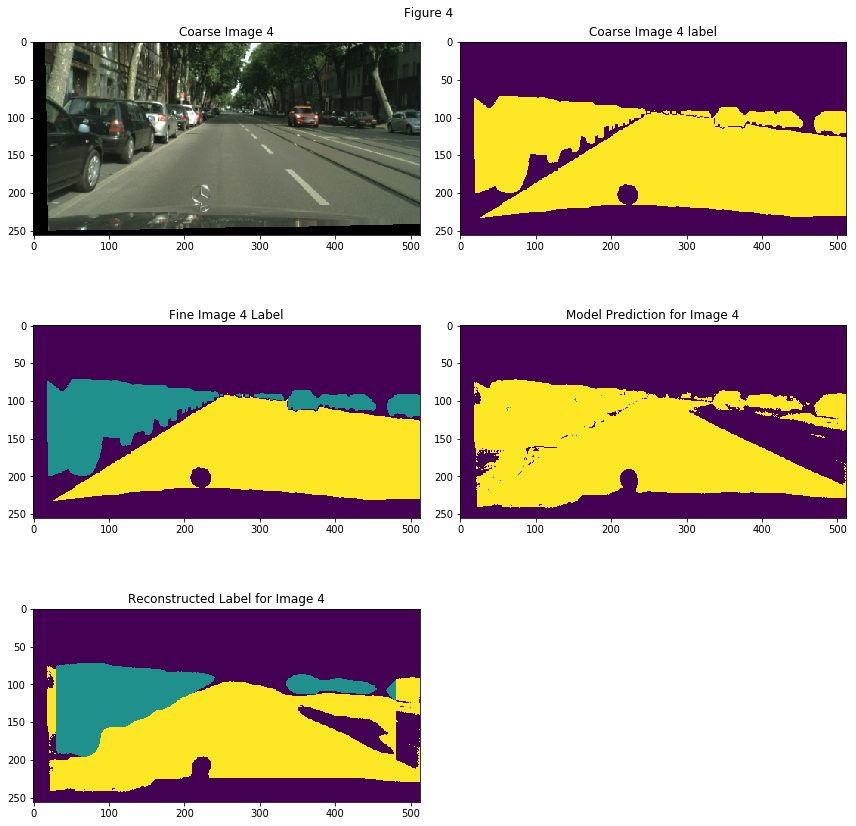

In [19]:
view_corrections_on_training_data(coarse_model, ec_model, n=5, ignore_pedestrians=ignore_pedestrians, 
                                  diff=False, use_model_pred=True, output_window_size=output_window_size, 
                                  input_window_size=input_window_size, use_x=True, coarse_or_miscl='miscl')

2975
2975
2975


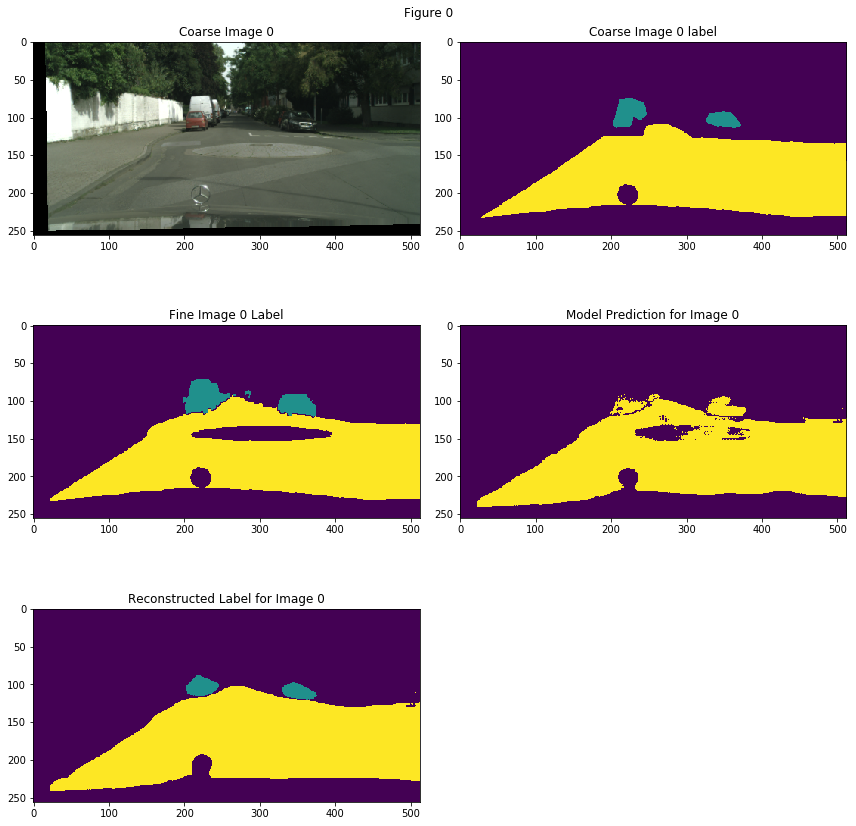

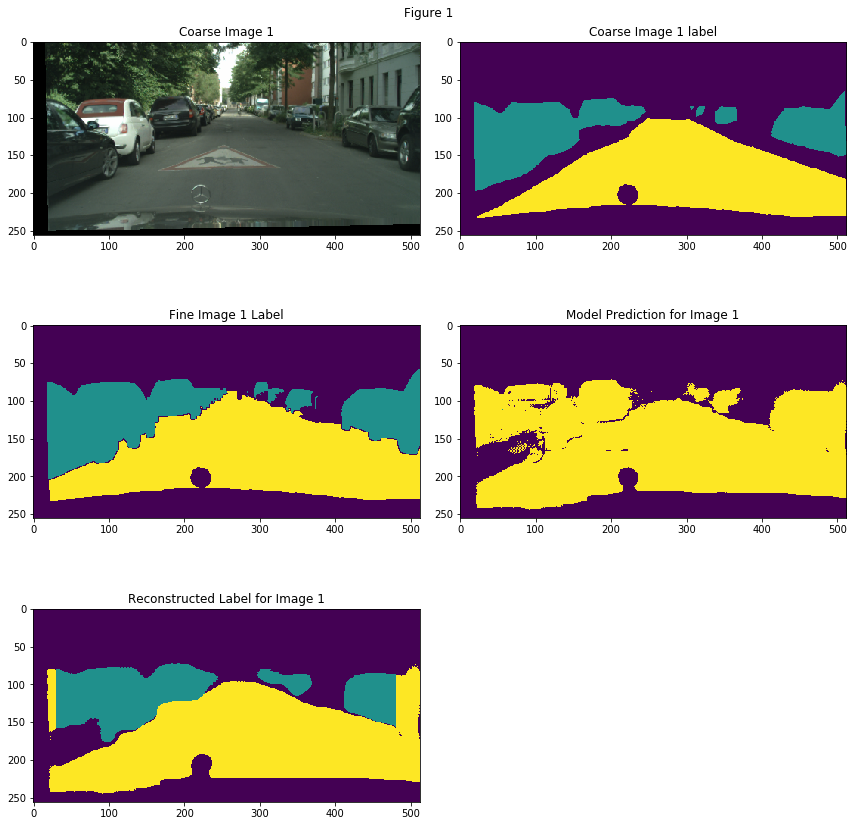

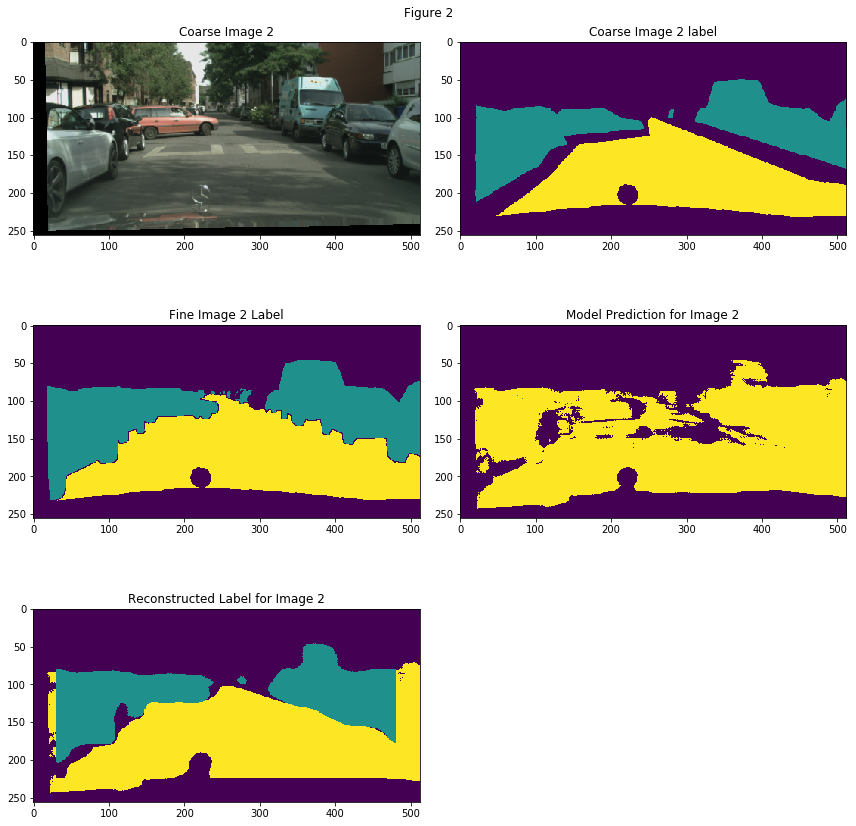

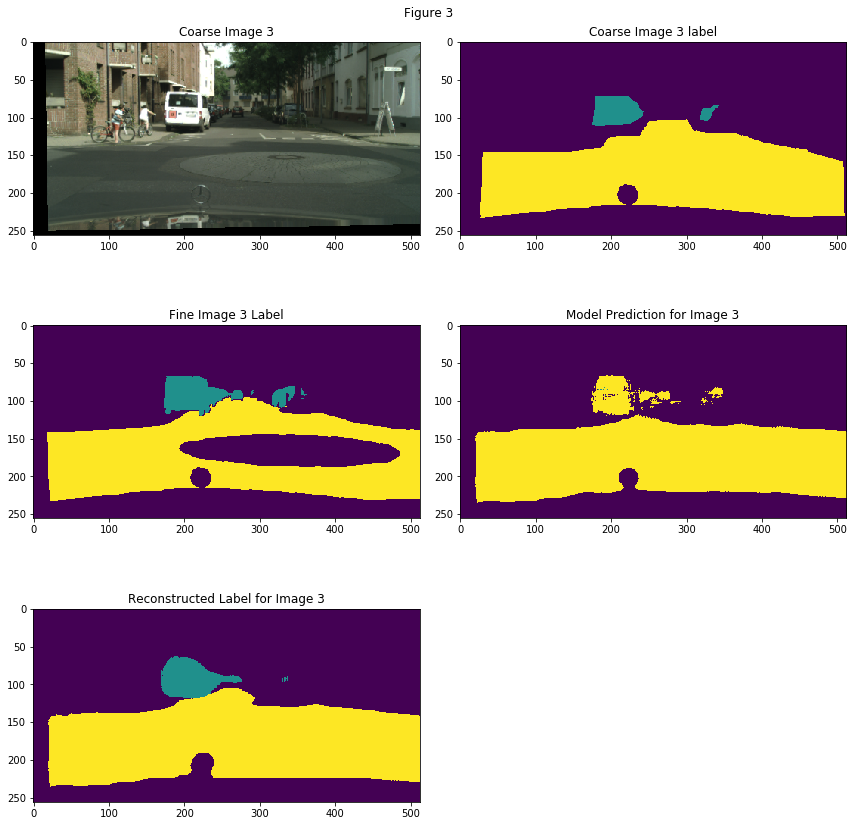

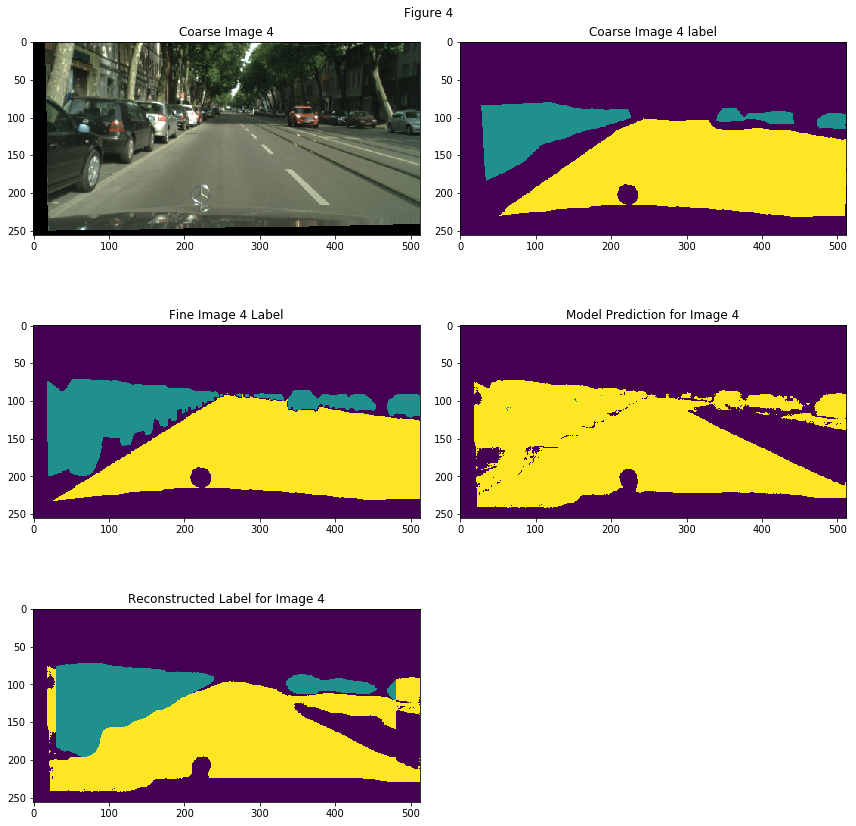

In [20]:
view_corrections_on_training_data(coarse_model, ec_model, n=5, ignore_pedestrians=ignore_pedestrians, 
                                  diff=False, use_model_pred=True, output_window_size=output_window_size, 
                                  input_window_size=input_window_size, use_x=True)